In [66]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, MobileNet, ResNet50
from tensorflow.keras.preprocessing import image
from collections import defaultdict
from shutil import copy
from shutil import copytree, rmtree

# Dataset Extraction 

In [10]:
# !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

In [11]:
# !tar xzvf food-101.tar.gz

In [12]:
!ls train | head -10

Anger
Fear
Happy
Neutral
Sad
Surprise


# Data Preparation

In [67]:
# number of images to feed into the NN for every batch
batch_size = 128
datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()
pic_size = 48
train_generator = datagen_train.flow_from_directory( "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory("test",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 18006 images belonging to 6 classes.
Found 6007 images belonging to 6 classes.


In [51]:
batch_size = 32
shape = (48,48)
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True, # randomly flip images
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.05, # randomly zoom image
    brightness_range=[0.4, 0.8],
    fill_mode="reflect"
    ) 

train_generator = datagen.flow_from_directory(
    directory="train",
    target_size=shape,
    color_mode="grayscale",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

# valid_generator = datagen.flow_from_directory(
#     directory="valid",
#     target_size=shape,
#     color_mode="grayscale",
#     shuffle=True,
#     batch_size=batch_size,
#     class_mode="categorical",
#     seed=2019)

test_generator = datagen.flow_from_directory(
    directory="test",
    target_size=shape,
    color_mode="grayscale",
    shuffle=False,
    batch_size=1,
    class_mode="categorical")

num_classes = len(train_generator.class_indices)

# create step size
STEP_SIZE_TRAIN=np.ceil(train_generator.n/train_generator.batch_size)
# STEP_SIZE_VALID=np.ceil(valid_generator.n/valid_generator.batch_size)
STEP_SIZE_TEST=np.ceil(test_generator.n/test_generator.batch_size)

print(STEP_SIZE_TRAIN)
# print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

Found 18006 images belonging to 6 classes.
Found 6007 images belonging to 6 classes.
563.0
6007.0


In [3]:

for expression in os.listdir("train"):
    print(str(len(os.listdir("train/" + expression))) + " " + expression + " images")
for expression in os.listdir("test"):
    print(str(len(os.listdir("test/" + expression))) + " " + expression + " images")

3001 Sad images
3001 Neutral images
3001 Happy images
3001 Fear images
3001 Anger images
3001 Surprise images
1001 Sad images
1001 Neutral images
1001 Happy images
1002 Fear images
1001 Anger images
1001 Surprise images


# Defining model 

In [15]:
!rm -rf .ip*

In [52]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 6

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
earlyStopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint = ModelCheckpoint(os.path.join("models", "model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), verbose=1, 
                             monitor="val_loss", save_best_only=True, mode="auto")
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode="min")

In [54]:
model.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=0.0001),
              metrics=["acc"])

In [62]:
model=load_model("models/model-vgg16-021-0.554093-0.552189.h5")

In [63]:
checkpoint = ModelCheckpoint(os.path.join("models", "model-vgg16-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_vgg = model.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=test_generator,
                                       validation_steps=STEP_SIZE_TEST,
                                       callbacks=[earlyStopping, checkpoint],
                                       epochs=50, verbose=2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 1.17789, saving model to models/model-vgg16-001-0.559091-0.531879.h5
563/563 - 31s - loss: 1.1394 - acc: 0.5591 - val_loss: 1.1779 - val_acc: 0.5319
Epoch 2/50

Epoch 00002: val_loss did not improve from 1.17789
563/563 - 33s - loss: 1.1344 - acc: 0.5596 - val_loss: 1.1965 - val_acc: 0.5352
Epoch 3/50

Epoch 00003: val_loss did not improve from 1.17789
563/563 - 31s - loss: 1.1312 - acc: 0.5569 - val_loss: 1.2640 - val_acc: 0.4983
Epoch 4/50

Epoch 00004: val_loss improved from 1.17789 to 1.16477, saving model to models/model-vgg16-004-0.564312-0.544864.h5
563/563 - 31s - loss: 1.1286 - acc: 0.5643 - val_loss: 1.1648 - val_acc: 0.5449
Epoch 5/50

Epoch 00005: val_loss did not improve from 1.16477
563/563 - 31s - loss: 1.1266 - acc: 0.5656 - val_loss: 1.1664 - val_acc: 0.5409
Epoch 6/50

Epoch 00006: val_loss improved from 1.16477 to 1.14929, saving model to models/model-vgg16-006-0.563923-0.553021.h5
563/563 - 31s - loss: 1.1256 - 

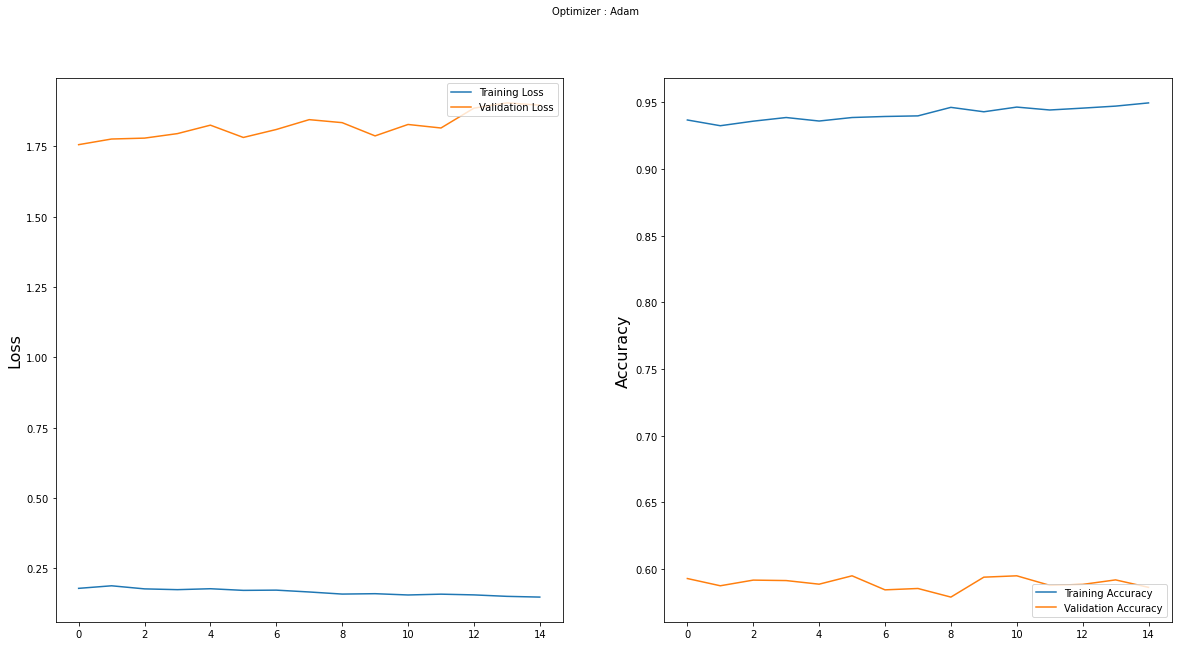

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

Instructions for updating:
Please use Model.predict, which supports generators.


<Figure size 432x288 with 0 Axes>

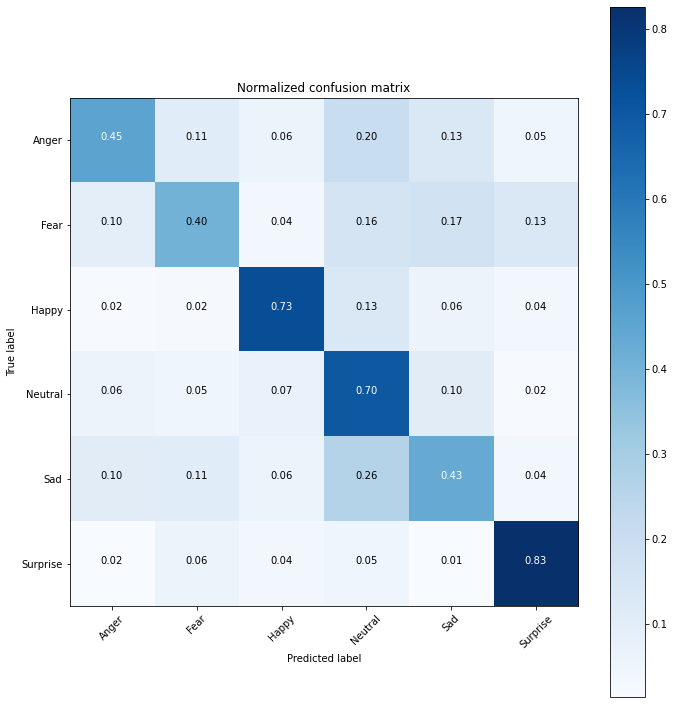

In [22]:
# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [ ]:
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

In [41]:
with open("fer20131.csv") as f:
    content = f.readlines()
 
    lines = np.array(content)
   
    num_ofbbbbinstances = lines.size
print("number of instances: ",num_of_instances)

number of instances:  32996


In [ ]:
#=========================new model=================

In [80]:
img = 
test_img = img.reshape((1,784))
img_class = model.predict_classes(test_img)
prediction = img_class[0]
classname = img_class[0]
print("Class: ",classname)

SyntaxError: invalid syntax (<ipython-input-80-c2f06563dd2b>, line 1)

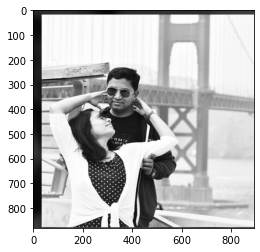

In [95]:
img = image.load_img(os.path.join( "fc.png"))
plt.imshow(img)

In [102]:
img = image.img_to_array(img) / 255
# predictions = model.predict(img)
# y_pred = [np.argmax(probas) for probas in predictions]
print(img.shape)
img = img.reshape(48, 48,1)
predictions = model.predict(img)

ValueError: Unsupported image shape: (1, 880, 892, 3)